In [1]:
import json
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Load data
df = pd.read_csv("modeling_dataframe.csv")  # or however you load it
df.drop(columns=['air_yards_for_model'], inplace=True)

y_col = "success_outcome"
X_cols = [c for c in df.columns if c != y_col]
X_all, y_all = df[X_cols], df[y_col]

# Load params
with open("rf_best_params_v2.json") as f:
    rf_params = json.load(f)
with open("gb_best_params_v2.json") as f:
    gb_params = json.load(f)

# Recreate tuned models
best_rf = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestRegressor(**rf_params, n_jobs=-1, random_state=42)
)
best_gb = HistGradientBoostingRegressor(**gb_params, random_state=42)

# Fit on full data
best_rf.fit(X_all, y_all)
best_gb.fit(X_all, y_all)

print("Models reloaded and refit. Ready for SHAP or evaluation.")

Models reloaded and refit. Ready for SHAP or evaluation.


100%|===================| 55451/55454 [261:15<00:00]         


[RF] Top 20 by mean |SHAP|:
 yards_after_catch_missing             0.118490
drive_play_index                      0.048025
yards_after_catch                     0.044403
route_GO                              0.027121
route_SCREEN                          0.016878
time_to_throw                         0.012500
route_CORNER                          0.011442
route_POST                            0.010386
defense_coverage_type_COVER_0         0.009213
route_FLAT                            0.007616
pass_rate_so_far                      0.004808
tod_unix                              0.003751
defense_man_zone_type_MAN_COVERAGE    0.003590
route_IN/DIG                          0.003205
defenders_in_box                      0.002604
route_SLANT                           0.002593
defense_coverage_type_COVER_1         0.002565
route_DEEP OUT                        0.002259
completion_rate_so_far                0.001802
route_SWING                           0.001751
dtype: float64


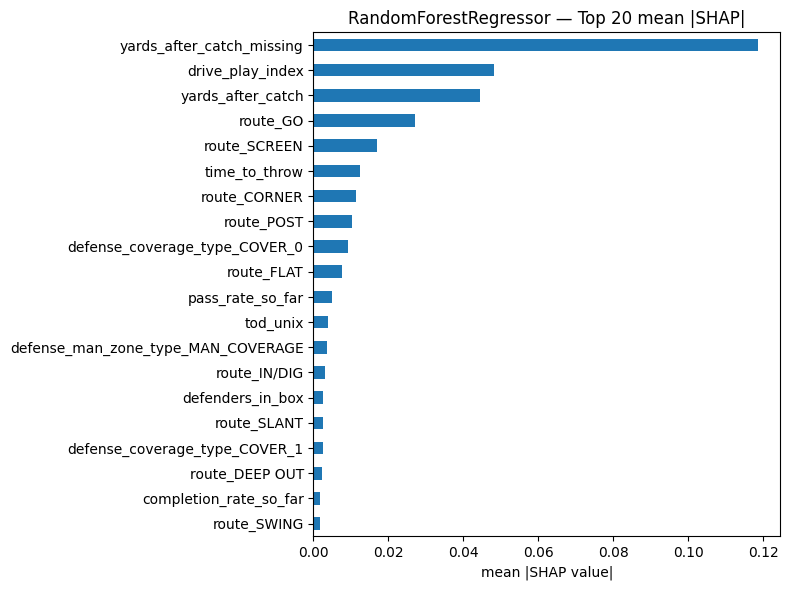

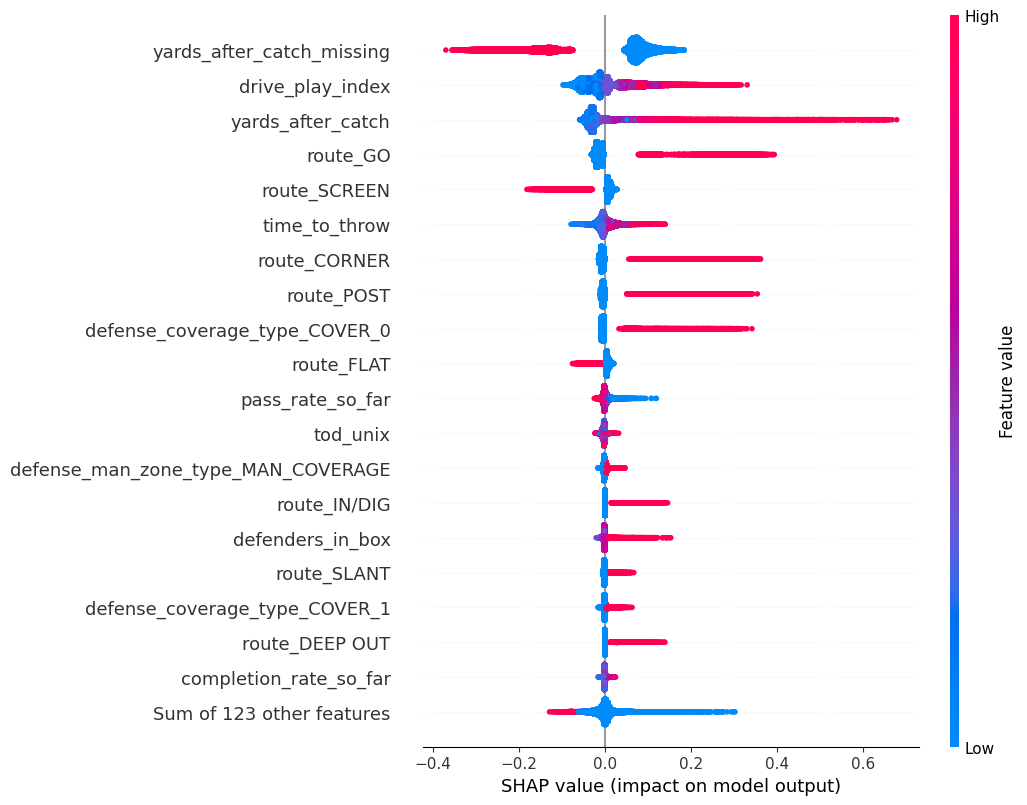

100%|===================| 55441/55454 [07:35<00:00]        


[HistGB] Top 20 by mean |SHAP|:
 yards_after_catch_missing             0.127805
drive_play_index                      0.053270
yards_after_catch                     0.046894
route_GO                              0.025527
time_to_throw                         0.016772
route_SCREEN                          0.014513
route_POST                            0.013212
route_FLAT                            0.012994
first_down_pass_so_far                0.012008
defense_coverage_type_COVER_0         0.010126
pass_rate_so_far                      0.008823
route_CORNER                          0.008620
first_down_rush_so_far                0.008329
game_seconds_remaining                0.007465
defenders_in_box                      0.006843
first_down_penalty_so_far             0.006707
defense_man_zone_type_MAN_COVERAGE    0.006169
defense_coverage_type_COVER_4         0.004892
offense_drive_number                  0.004612
route_WHEEL                           0.004104
dtype: float64


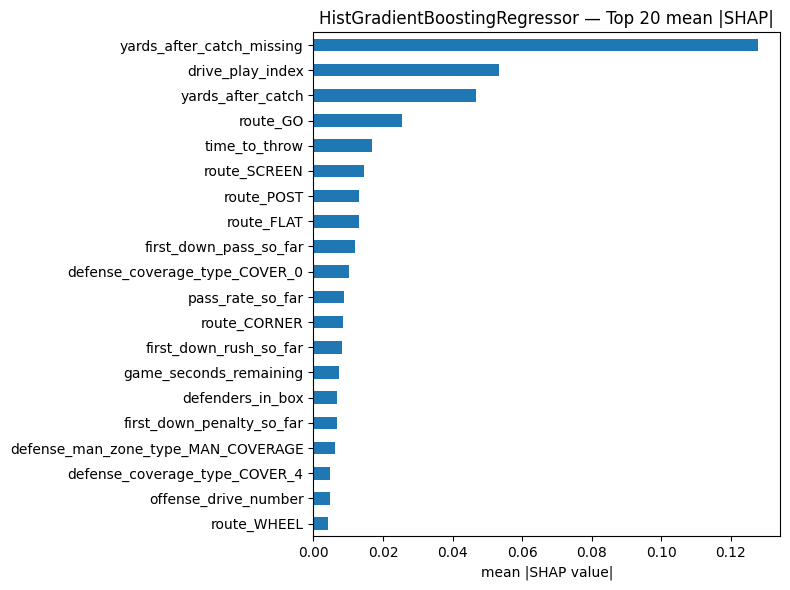

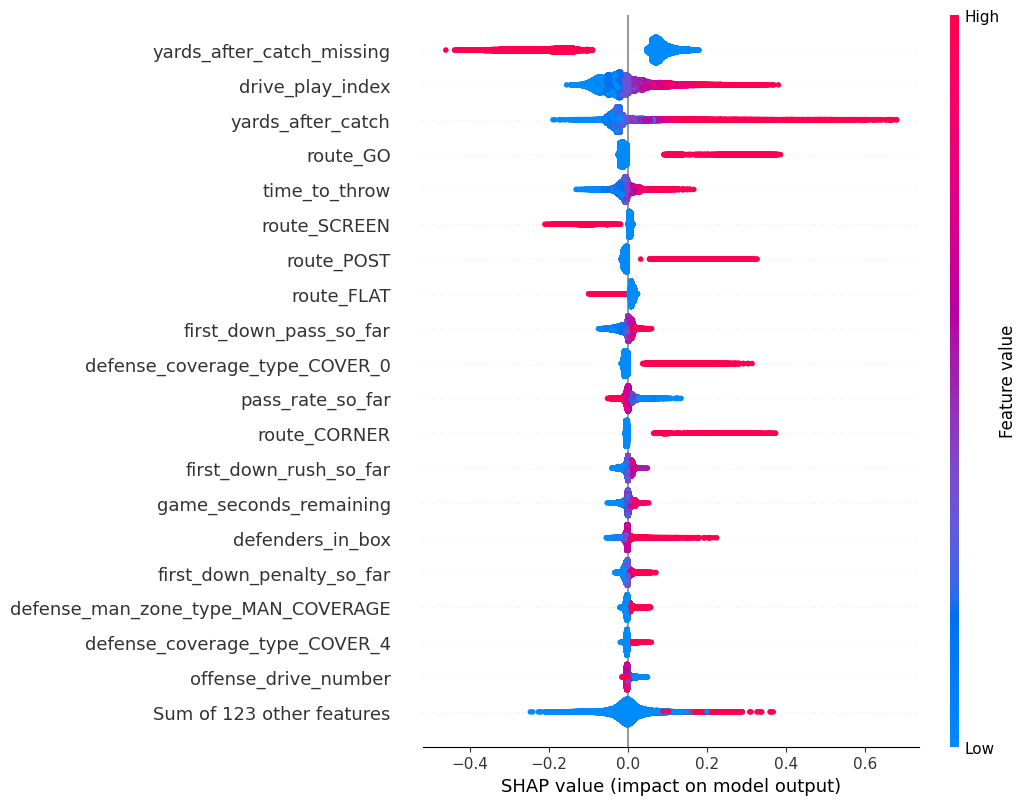

Saved: rf_shap_importance_v2.csv, histgb_shap_importance_v2.csv


In [3]:
# ===== SHAP (robust) for RF (pipeline) and HistGB =====
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# --------------------
# 0) Setup & feature names
# --------------------
feature_names = X_all.columns.tolist()

# --------------------
# 1) RandomForestRegressor (pipeline: SimpleImputer -> RF)
# --------------------
# Grab steps safely
rf_imputer = None
rf_model = None
for name, step in best_rf.named_steps.items():
    if isinstance(step, SimpleImputer):
        rf_imputer = step
    if isinstance(step, RandomForestRegressor):
        rf_model = step
assert rf_imputer is not None and rf_model is not None, "Could not find SimpleImputer/RF in best_rf pipeline."

# Transform X (exactly like training)
X_rf = rf_imputer.transform(X_all).astype("float64")  # <- RF got imputed float64 array

# Small, representative background for the masker (no legacy DenseData)
bg_rf = X_rf[: min(256, len(X_rf))]
masker_rf = shap.maskers.Independent(bg_rf)

# Force tree algorithm; disable additivity check (tiny numeric diffs are common)
rf_explainer = shap.Explainer(rf_model, masker_rf, algorithm="tree")
rf_exp = rf_explainer(X_rf, check_additivity=False)
rf_values = rf_exp.values  # (n_samples, n_features)

# Global importance
rf_importance = np.abs(rf_values).mean(axis=0)
rf_importance_s = pd.Series(rf_importance, index=feature_names).sort_values(ascending=False)
print("\n[RF] Top 20 by mean |SHAP|:\n", rf_importance_s.head(20))

# Plot
plt.figure(figsize=(8,6))
rf_importance_s.head(20)[::-1].plot(kind='barh')
plt.title("RandomForestRegressor — Top 20 mean |SHAP|")
plt.xlabel("mean |SHAP value|")
plt.tight_layout()
plt.show()

# Beeswarm (optional)
try:
    shap.plots.beeswarm(
        shap.Explanation(
            values=rf_values,
            base_values=getattr(rf_exp, "base_values", None),
            data=X_rf,
            feature_names=feature_names
        ),
        max_display=20, show=True
    )
except Exception as e:
    print(f"[RF] Beeswarm skipped: {e}")

# --------------------
# 2) HistGradientBoostingRegressor
# --------------------
# IMPORTANT: Feed the explainer the same *raw* feature shape/dtypes HGB saw.
# HGB was fit on X_all directly (no imputer), so use float64 DataFrame/array.
X_gb_np = X_all.astype("float64").values  # preserve shape & NaNs as seen in training

# Background for masker
bg_gb = X_gb_np[: min(1000, len(X_gb_np))]
masker_gb = shap.maskers.Independent(bg_gb)

# Generic explainer with tree backend; disable additivity
gb_explainer = shap.Explainer(best_gb, masker_gb, algorithm="tree")
gb_exp = gb_explainer(X_gb_np, check_additivity=False)
gb_values = gb_exp.values  # (n_samples, n_features)

# If your environment still trips, uncomment this bulletproof (but slower) fallback:
# from shap.explainers import Permutation
# gb_perm = Permutation(best_gb.predict, masker_gb)
# gb_exp = gb_perm(X_gb_np)  # check_additivity not enforced
# gb_values = gb_exp.values

# Global importance
gb_importance = np.abs(gb_values).mean(axis=0)
gb_importance_s = pd.Series(gb_importance, index=feature_names).sort_values(ascending=False)
print("\n[HistGB] Top 20 by mean |SHAP|:\n", gb_importance_s.head(20))

# Plot
plt.figure(figsize=(8,6))
gb_importance_s.head(20)[::-1].plot(kind='barh')
plt.title("HistGradientBoostingRegressor — Top 20 mean |SHAP|")
plt.xlabel("mean |SHAP value|")
plt.tight_layout()
plt.show()

# Beeswarm (optional)
try:
    shap.plots.beeswarm(
        shap.Explanation(
            values=gb_values,
            base_values=getattr(gb_exp, "base_values", None),
            data=X_gb_np,
            feature_names=feature_names
        ),
        max_display=20, show=True
    )
except Exception as e:
    print(f"[HistGB] Beeswarm skipped: {e}")

# --------------------
# 3) Save importances
# --------------------
rf_importance_s.to_csv("rf_shap_importance_v2.csv")
gb_importance_s.to_csv("histgb_shap_importance_v2.csv")
print("Saved: rf_shap_importance_v2.csv, histgb_shap_importance_v2.csv")
